## LOAD LIBRARIES

First, let's import the libraries

In [0]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import stats
import pandas as pd 
import multiprocessing
import random

from matplotlib import rc
from sklearn.preprocessing import scale
from sklearn.preprocessing import OneHotEncoder
import timeit
import itertools
import seaborn as sns
from collections import Counter
import operator

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


##DATAFRAME

Start creating the variables and its possible values.

In [0]:
data1=pd.DataFrame()
data1['Age'] = ['0-9','10-19', '20-29', '30-39', '40-49','50-59','60-69','70-79','80-89','>90']

data2=pd.DataFrame()
data2['Tipo_de_enfermedad'] = ["Enfermedad cardiovascular/Insuficiencia cardiaca","EPOC/Asma/Insuficiencia respiratoria","Diabetes/Obesidad","Hipertensión/Colesterol","Insuficiencia renal crónica","Cáncer","Enfermedad neurológica","Enfermedad hepática","Inmunodepresión"]

data3=pd.DataFrame()
data3['Fumador'] = ['Yes','No']

lista = [data1,data2,data3]
data = pd.concat(lista, axis=1)


Show Raw-Data 

In [0]:
data

,Age,Tipo_de_enfermedad,Fumador
0,0-9,Enfermedad cardiovascular/Insuficiencia cardiaca,Yes
1,10-19,EPOC/Asma/Insuficiencia respiratoria,No
2,20-29,Diabetes/Obesidad,NaN
3,30-39,Hipertensión/Colesterol,NaN
4,40-49,Insuficiencia renal crónica,NaN
5,50-59,Cáncer,NaN
6,60-69,Enfermedad neurológica,NaN
7,70-79,Enfermedad hepática,NaN
8,80-89,Inmunodepresión,NaN
9,>90,NaN,NaN


Delate Nan Values and observe all possible combinations.

In [0]:
age = len(data.Age.dropna().unique())
disease = len(data.Tipo_de_enfermedad.dropna().unique())
smoker = len(data.Fumador.dropna().unique())

print("Total Combination Possible: ",age * disease * smoker )

Total Combination Possible:  180


We define a formula that calculates and returns the power set of the set c.


In [0]:
def potencia(c):
  
    if len(c) == 0:
        return [[]]
    r = potencia(c[:-1])
    return r + [s + [c[-1]] for s in r]

All disease combinations are created.

In [0]:
comb_enfermedades=potencia(["Enfermedad cardiovascular/Insuficiencia cardiaca","EPOC/Asma/Insuficiencia respiratoria","Diabetes/Obesidad","Hipertensión/Colesterol","Insuficiencia renal crónica","Cáncer","Enfermedad neurológica","Enfermedad hepática","Inmunodepresión"])
comb_enfermedades

[[],
 ['Enfermedad cardiovascular/Insuficiencia cardiaca'],
 ['EPOC/Asma/Insuficiencia respiratoria'],
 ['Enfermedad cardiovascular/Insuficiencia cardiaca',
  'EPOC/Asma/Insuficiencia respiratoria'],
 ['Diabetes/Obesidad'],
 ['Enfermedad cardiovascular/Insuficiencia cardiaca', 'Diabetes/Obesidad'],
 ['EPOC/Asma/Insuficiencia respiratoria', 'Diabetes/Obesidad'],
 ['Enfermedad cardiovascular/Insuficiencia cardiaca',
  'EPOC/Asma/Insuficiencia respiratoria',
  'Diabetes/Obesidad'],
 ['Hipertensión/Colesterol'],
 ['Enfermedad cardiovascular/Insuficiencia cardiaca',
  'Hipertensión/Colesterol'],
 ['EPOC/Asma/Insuficiencia respiratoria', 'Hipertensión/Colesterol'],
 ['Enfermedad cardiovascular/Insuficiencia cardiaca',
  'EPOC/Asma/Insuficiencia respiratoria',
  'Hipertensión/Colesterol'],
 ['Diabetes/Obesidad', 'Hipertensión/Colesterol'],
 ['Enfermedad cardiovascular/Insuficiencia cardiaca',
  'Diabetes/Obesidad',
  'Hipertensión/Colesterol'],
 ['EPOC/Asma/Insuficiencia respiratoria',
  'Dia

Create a new DataFrame with the possible combination. 2^9 possible disease combinations. 

In [0]:
comb_enfer=comb_enfermedades
comb_enfer=pd.DataFrame({'Enfermedades': comb_enfermedades})
comb_enfer

,Enfermedades
0,[]
1,[Enfermedad cardiovascular/Insuficiencia cardi...
2,[EPOC/Asma/Insuficiencia respiratoria]
3,[Enfermedad cardiovascular/Insuficiencia cardi...
4,[Diabetes/Obesidad]
...,...
507,[Enfermedad cardiovascular/Insuficiencia cardi...
508,"[Diabetes/Obesidad, Hipertensión/Colesterol, I..."
509,[Enfermedad cardiovascular/Insuficiencia cardi...
510,"[EPOC/Asma/Insuficiencia respiratoria, Diabete..."


Merge both "data" and "comb_enfer" datasets. Variable "Tipo_de_enfermedad" is removed.

In [0]:
data_final=pd.concat([data, comb_enfer], axis=1, sort=False)
del data_final['Tipo_de_enfermedad']
data_final

,Age,Fumador,Enfermedades
0,0-9,Yes,[]
1,10-19,No,[Enfermedad cardiovascular/Insuficiencia cardi...
2,20-29,NaN,[EPOC/Asma/Insuficiencia respiratoria]
3,30-39,NaN,[Enfermedad cardiovascular/Insuficiencia cardi...
4,40-49,NaN,[Diabetes/Obesidad]
...,...,...,...
507,NaN,NaN,[Enfermedad cardiovascular/Insuficiencia cardi...
508,NaN,NaN,"[Diabetes/Obesidad, Hipertensión/Colesterol, I..."
509,NaN,NaN,[Enfermedad cardiovascular/Insuficiencia cardi...
510,NaN,NaN,"[EPOC/Asma/Insuficiencia respiratoria, Diabete..."


Variable "Enfermedad" is modified. This variable is adequated to the post application of dummies.

In [0]:
def try_join(l):
    try:
        return ','.join(map(str, l))
    except TypeError:
        return np.nan

data_final['Enfermedad'] = [try_join(l) for l in data_final['Enfermedades']]
del data_final['Enfermedades']

Show data final with all the possible combinations

In [0]:
data_final

,Age,Fumador,Enfermedad
0,0-9,Yes,
1,10-19,No,Enfermedad cardiovascular/Insuficiencia cardiaca
2,20-29,NaN,EPOC/Asma/Insuficiencia respiratoria
3,30-39,NaN,Enfermedad cardiovascular/Insuficiencia cardia...
4,40-49,NaN,Diabetes/Obesidad
...,...,...,...
507,NaN,NaN,Enfermedad cardiovascular/Insuficiencia cardia...
508,NaN,NaN,"Diabetes/Obesidad,Hipertensión/Colesterol,Insu..."
509,NaN,NaN,Enfermedad cardiovascular/Insuficiencia cardia...
510,NaN,NaN,"EPOC/Asma/Insuficiencia respiratoria,Diabetes/..."


NaNs are removed. Also, total possible combination is computed. As we can see, total combinations are 512x10x2= 10.240

In [0]:
age = len(data_final.Age.dropna().unique())
disease = len(data_final.Enfermedad.dropna().unique())
smoker = len(data_final.Fumador.dropna().unique())

print("Total Combination Possible: ",age * disease * smoker )

Total Combination Possible:  10240


Now, let's convert the series we create into list.

In [0]:
columns = [data_final.Age.dropna().unique().tolist(),
          data_final.Fumador.dropna().unique().tolist(),
          data_final.Enfermedad.dropna().unique().tolist()]

final_data = pd.DataFrame(list(itertools.product(*columns)), columns=data_final.columns)

Let's check the composition of "final_data".

In [0]:
final_data.shape

(10240, 3)

In [0]:
final_data.head()

,Age,Fumador,Enfermedad
0,0-9,Yes,
1,0-9,Yes,Enfermedad cardiovascular/Insuficiencia cardiaca
2,0-9,Yes,EPOC/Asma/Insuficiencia respiratoria
3,0-9,Yes,Enfermedad cardiovascular/Insuficiencia cardia...
4,0-9,Yes,Diabetes/Obesidad


"Enfermedad" values are converted into dummies. As you can see, we cannot apply the direct dummies function because it is a list of several diseases. Thus, we use a counter.

In [0]:
disease_list = final_data['Enfermedad'].str.split(',')

disease_counter = Counter(([a for b in disease_list.tolist() for a in b]))

for Enfermedad in disease_counter.keys():
    final_data[Enfermedad] = 0
    final_data.loc[final_data['Enfermedad'].str.contains(Enfermedad), Enfermedad] = 1

final_data.head(50)

,Age,Fumador,Enfermedad,,Enfermedad cardiovascular/Insuficiencia cardiaca,EPOC/Asma/Insuficiencia respiratoria,Diabetes/Obesidad,Hipertensión/Colesterol,Insuficiencia renal crónica,Cáncer,Enfermedad neurológica,Enfermedad hepática,Inmunodepresión
0,0-9,Yes,,1,0,0,0,0,0,0,0,0,0
1,0-9,Yes,Enfermedad cardiovascular/Insuficiencia cardiaca,1,1,0,0,0,0,0,0,0,0
2,0-9,Yes,EPOC/Asma/Insuficiencia respiratoria,1,0,1,0,0,0,0,0,0,0
3,0-9,Yes,Enfermedad cardiovascular/Insuficiencia cardia...,1,1,1,0,0,0,0,0,0,0
4,0-9,Yes,Diabetes/Obesidad,1,0,0,1,0,0,0,0,0,0
5,0-9,Yes,Enfermedad cardiovascular/Insuficiencia cardia...,1,1,0,1,0,0,0,0,0,0
6,0-9,Yes,"EPOC/Asma/Insuficiencia respiratoria,Diabetes/...",1,0,1,1,0,0,0,0,0,0
7,0-9,Yes,Enfermedad cardiovascular/Insuficiencia cardia...,1,1,1,1,0,0,0,0,0,0
8,0-9,Yes,Hipertensión/Colesterol,1,0,0,0,1,0,0,0,0,0
9,0-9,Yes,Enfermedad cardiovascular/Insuficiencia cardia...,1,1,0,0,1,0,0,0,0,0


A dummy has been generated that shows the effect of not having any disease. Simultaneously, combinations have already been created in which there is no disease (disease dummies=0), so we proceed to eliminate this column to avoid redundancy. 

In [0]:
del final_data['']

In [0]:
final_data.shape

(10240, 12)

In addition, the column "Enfermedad" is also eliminated because we have already converted them into dummies. We also convert disease, age and smoke variables into dummies.

In [0]:
final_data = final_data.drop(['Enfermedad'],axis=1)
dummies = pd.get_dummies(final_data)
final_data = dummies
final_data.head(5)

,Enfermedad cardiovascular/Insuficiencia cardiaca,EPOC/Asma/Insuficiencia respiratoria,Diabetes/Obesidad,Hipertensión/Colesterol,Insuficiencia renal crónica,Cáncer,Enfermedad neurológica,Enfermedad hepática,Inmunodepresión,Age_0-9,Age_10-19,Age_20-29,Age_30-39,Age_40-49,Age_50-59,Age_60-69,Age_70-79,Age_80-89,Age_>90,Fumador_No,Fumador_Yes
0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
2,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
3,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
4,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1


Possibility of smoking with the age between 0 and 9 is removed

In [0]:
final_data = final_data.drop(final_data[(final_data['Age_0-9']==1) & (final_data['Fumador_Yes']==1)].index)
final_data

,Enfermedad cardiovascular/Insuficiencia cardiaca,EPOC/Asma/Insuficiencia respiratoria,Diabetes/Obesidad,Hipertensión/Colesterol,Insuficiencia renal crónica,Cáncer,Enfermedad neurológica,Enfermedad hepática,Inmunodepresión,Age_0-9,Age_10-19,Age_20-29,Age_30-39,Age_40-49,Age_50-59,Age_60-69,Age_70-79,Age_80-89,Age_>90,Fumador_No,Fumador_Yes
512,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
513,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
514,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
515,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
516,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10235,1,1,0,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,1,1,0
10236,0,0,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,1,1,0
10237,1,0,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,1,1,0
10238,0,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,1,1,0


## DATA QUALITY

At this point, let's check the quality of the created dataset.

In [0]:
final_data.shape

(9728, 21)

Let's check "final_data" after applying these modifications.

Check the first 5 lines of our new dataset.

In [0]:
final_data.head(5)

,Enfermedad cardiovascular/Insuficiencia cardiaca,EPOC/Asma/Insuficiencia respiratoria,Diabetes/Obesidad,Hipertensión/Colesterol,Insuficiencia renal crónica,Cáncer,Enfermedad neurológica,Enfermedad hepática,Inmunodepresión,Age_0-9,Age_10-19,Age_20-29,Age_30-39,Age_40-49,Age_50-59,Age_60-69,Age_70-79,Age_80-89,Age_>90,Fumador_No,Fumador_Yes
512,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
513,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
514,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
515,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
516,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0


Check the last 5 lines of the dataset.

In [0]:
final_data.tail(5)

,Enfermedad cardiovascular/Insuficiencia cardiaca,EPOC/Asma/Insuficiencia respiratoria,Diabetes/Obesidad,Hipertensión/Colesterol,Insuficiencia renal crónica,Cáncer,Enfermedad neurológica,Enfermedad hepática,Inmunodepresión,Age_0-9,Age_10-19,Age_20-29,Age_30-39,Age_40-49,Age_50-59,Age_60-69,Age_70-79,Age_80-89,Age_>90,Fumador_No,Fumador_Yes
10235,1,1,0,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,1,1,0
10236,0,0,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,1,1,0
10237,1,0,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,1,1,0
10238,0,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,1,1,0
10239,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,1,1,0


Observe the info of the created dataset.

In [0]:
final_data.info

<bound method DataFrame.info of        Enfermedad cardiovascular/Insuficiencia cardiaca  ...  Fumador_Yes
512                                                   0  ...            0
513                                                   1  ...            0
514                                                   0  ...            0
515                                                   1  ...            0
516                                                   0  ...            0
...                                                 ...  ...          ...
10235                                                 1  ...            0
10236                                                 0  ...            0
10237                                                 1  ...            0
10238                                                 0  ...            0
10239                                                 1  ...            0

[9728 rows x 21 columns]>

Dataset description.


In [0]:
description = final_data.describe()
description

,Enfermedad cardiovascular/Insuficiencia cardiaca,EPOC/Asma/Insuficiencia respiratoria,Diabetes/Obesidad,Hipertensión/Colesterol,Insuficiencia renal crónica,Cáncer,Enfermedad neurológica,Enfermedad hepática,Inmunodepresión,Age_0-9,Age_10-19,Age_20-29,Age_30-39,Age_40-49,Age_50-59,Age_60-69,Age_70-79,Age_80-89,Age_>90,Fumador_No,Fumador_Yes
count,9728.000000,9728.000000,9728.000000,9728.000000,9728.000000,9728.000000,9728.000000,9728.000000,9728.000000,9728.000000,9728.000000,9728.000000,9728.000000,9728.000000,9728.000000,9728.000000,9728.000000,9728.000000,9728.000000,9728.000000,9728.000000
mean,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.052632,0.105263,0.105263,0.105263,0.105263,0.105263,0.105263,0.105263,0.105263,0.105263,0.526316,0.473684
std,0.500026,0.500026,0.500026,0.500026,0.500026,0.500026,0.500026,0.500026,0.500026,0.223308,0.306908,0.306908,0.306908,0.306908,0.306908,0.306908,0.306908,0.306908,0.306908,0.499333,0.499333
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Variable types


In [0]:
final_data.dtypes

Enfermedad cardiovascular/Insuficiencia cardiaca    int64
EPOC/Asma/Insuficiencia respiratoria                int64
Diabetes/Obesidad                                   int64
Hipertensión/Colesterol                             int64
Insuficiencia renal crónica                         int64
Cáncer                                              int64
Enfermedad neurológica                              int64
Enfermedad hepática                                 int64
Inmunodepresión                                     int64
Age_0-9                                             uint8
Age_10-19                                           uint8
Age_20-29                                           uint8
Age_30-39                                           uint8
Age_40-49                                           uint8
Age_50-59                                           uint8
Age_60-69                                           uint8
Age_70-79                                           uint8
Age_80-89     

In [0]:
final_data.groupby("Enfermedad cardiovascular/Insuficiencia cardiaca").size()

Enfermedad cardiovascular/Insuficiencia cardiaca
0    4864
1    4864
dtype: int64

In [0]:
final_data.groupby("EPOC/Asma/Insuficiencia respiratoria").size()

EPOC/Asma/Insuficiencia respiratoria
0    4864
1    4864
dtype: int64

In [0]:
final_data.groupby("Diabetes/Obesidad").size()

Diabetes/Obesidad
0    4864
1    4864
dtype: int64

In [0]:
final_data.groupby("Hipertensión/Colesterol").size()

Hipertensión/Colesterol
0    4864
1    4864
dtype: int64

In [0]:
final_data.groupby("Insuficiencia renal crónica").size()

Insuficiencia renal crónica
0    4864
1    4864
dtype: int64

In [0]:
final_data.groupby("Cáncer").size()

Cáncer
0    4864
1    4864
dtype: int64

In [0]:
final_data.groupby("Enfermedad neurológica").size()

Enfermedad neurológica
0    4864
1    4864
dtype: int64

In [0]:
final_data.groupby("Enfermedad hepática").size()

Enfermedad hepática
0    4864
1    4864
dtype: int64

In [0]:
final_data.groupby("Inmunodepresión").size()

Inmunodepresión
0    4864
1    4864
dtype: int64

In [0]:
final_data.groupby("Age_0-9").size()

Age_0-9
0    9216
1     512
dtype: int64

In [0]:
final_data.groupby("Age_10-19").size()

Age_10-19
0    8704
1    1024
dtype: int64

In [0]:
final_data.groupby("Age_20-29").size()

Age_20-29
0    8704
1    1024
dtype: int64

In [0]:
final_data.groupby("Age_30-39").size()

Age_30-39
0    8704
1    1024
dtype: int64

In [0]:
final_data.groupby("Age_40-49").size()

Age_40-49
0    8704
1    1024
dtype: int64

In [0]:
final_data.groupby("Age_50-59").size()

Age_50-59
0    8704
1    1024
dtype: int64

In [0]:
final_data.groupby("Age_60-69").size()

Age_60-69
0    8704
1    1024
dtype: int64

In [0]:
final_data.groupby("Age_70-79").size()

Age_70-79
0    8704
1    1024
dtype: int64

In [0]:
final_data.groupby("Age_80-89").size()

Age_80-89
0    8704
1    1024
dtype: int64

In [0]:
final_data.groupby("Age_>90").size()

Age_>90
0    8704
1    1024
dtype: int64

In [0]:
final_data.groupby("Fumador_No").size()

Fumador_No
0    4608
1    5120
dtype: int64

In [0]:
final_data.groupby("Fumador_Yes").size()

Fumador_Yes
0    5120
1    4608
dtype: int64

Missing values

In [0]:
missing_values = final_data.isnull().sum()
missing_values

Enfermedad cardiovascular/Insuficiencia cardiaca    0
EPOC/Asma/Insuficiencia respiratoria                0
Diabetes/Obesidad                                   0
Hipertensión/Colesterol                             0
Insuficiencia renal crónica                         0
Cáncer                                              0
Enfermedad neurológica                              0
Enfermedad hepática                                 0
Inmunodepresión                                     0
Age_0-9                                             0
Age_10-19                                           0
Age_20-29                                           0
Age_30-39                                           0
Age_40-49                                           0
Age_50-59                                           0
Age_60-69                                           0
Age_70-79                                           0
Age_80-89                                           0
Age_>90                     

% Missing values 

In [0]:
total_cells = np.product(final_data.shape)
print('Nº cells:',total_cells)
total_missing_values = missing_values.sum()
print('Nº missing values:',total_missing_values)
percentage = total_missing_values/total_cells*100
print('Percentage of total missing values:',percentage)

Nº cells: 204288
Nº missing values: 0
Percentage of total missing values: 0.0


Plots

In this case, all the variable are binary so we have value  or  yes or not. But the variable age is only one posibility of the 10 groups and the average is low.

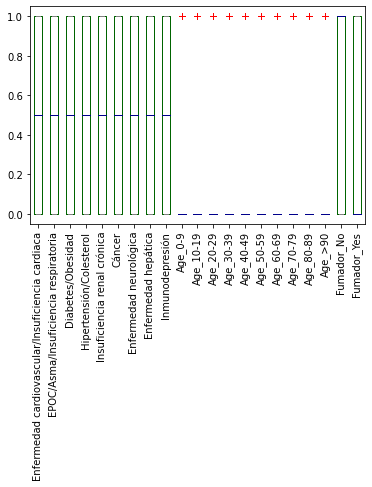

In [0]:
#Box Plot
# Box = green # Wisker = orange # Median = blue # Flier = red
color = dict(boxes='DarkGreen', whiskers='DarkOrange',medians='DarkBlue', caps='Gray')
final_data.plot(kind='box', color=color, sym='r+')
plt.xticks(rotation=90)
plt.show()

Barplot variables

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """


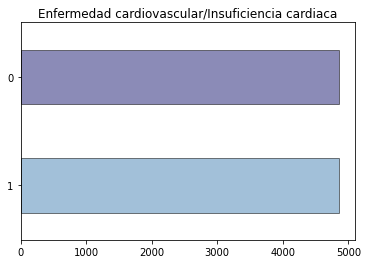

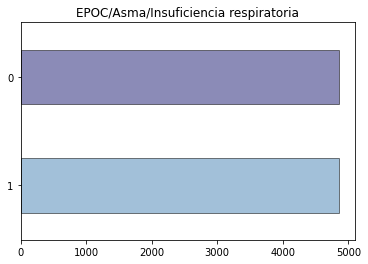

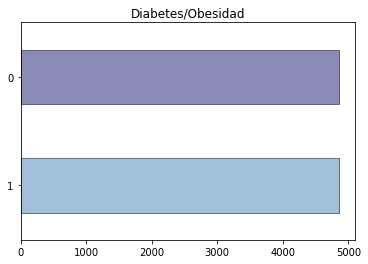

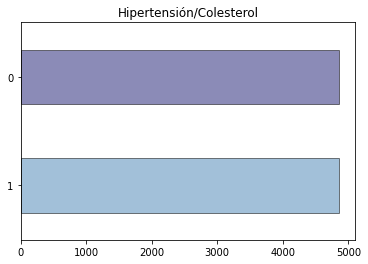

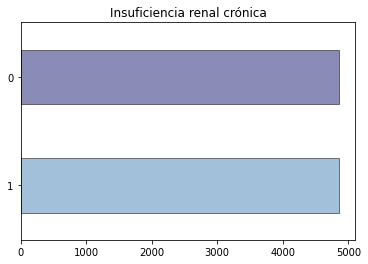

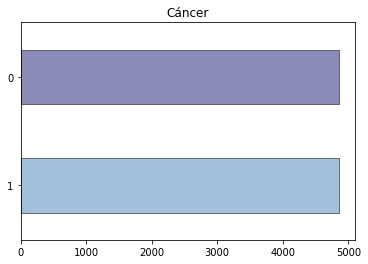

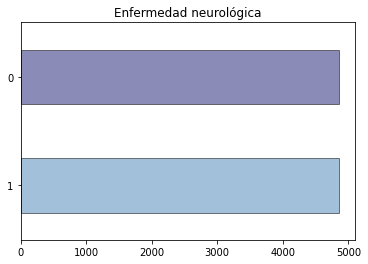

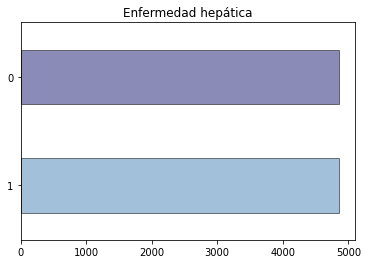

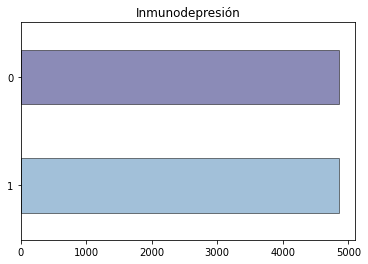

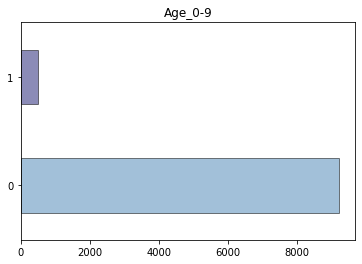

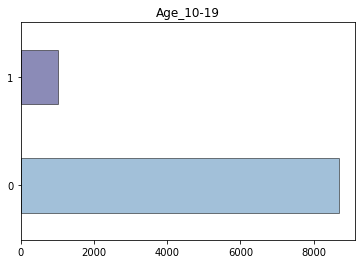

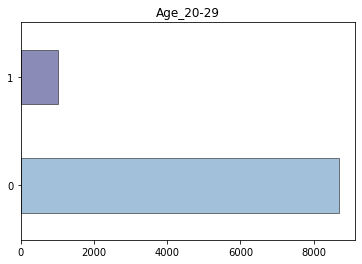

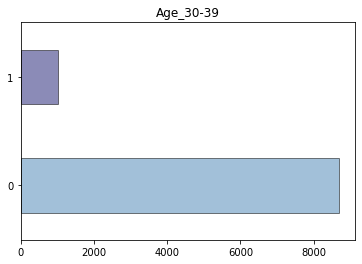

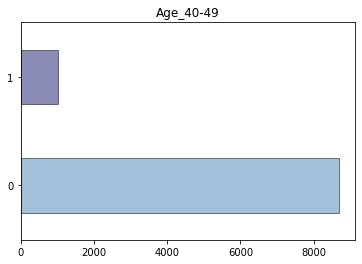

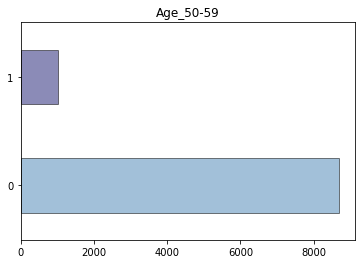

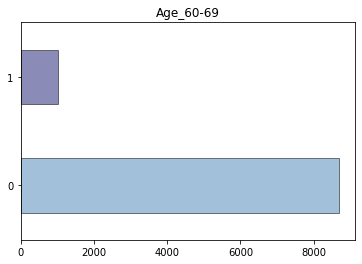

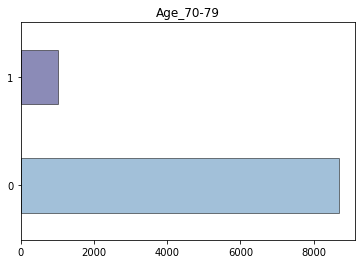

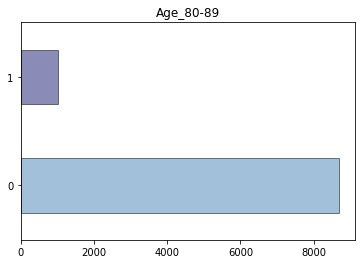

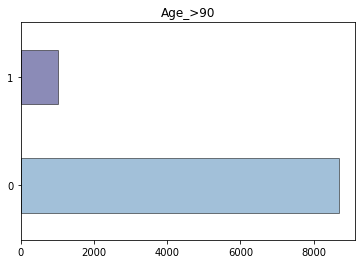

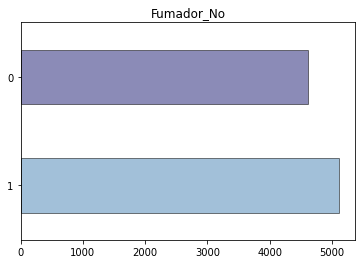

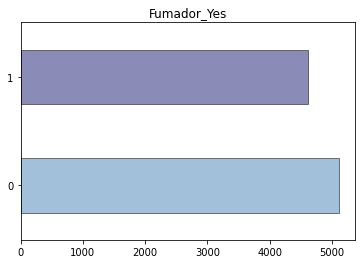

In [0]:
col_names = final_data.columns.tolist()
col_number= len(col_names)
a=0
for i in col_names:
  plt.figure(a)
  final_data[i].value_counts().plot(kind='barh',alpha=0.5, color=['#4682B4', '#191970'], edgecolor='black')
  plt.title(i)
  a=a+1

Stacked Bar Chart


This is a stacked bar char where we can see the total number of users (dark blue) and the number ob persons for each variable (light blue).

In [0]:
(users,y)=final_data.shape
afirmativo= [0]*col_number
n_users= [users]*col_number
afirmativo
a=0
for i in col_names:
  afirmativo[a]=final_data[i].sum()
  n_users[a]=n_users[a]-afirmativo[a]
  a=a+1


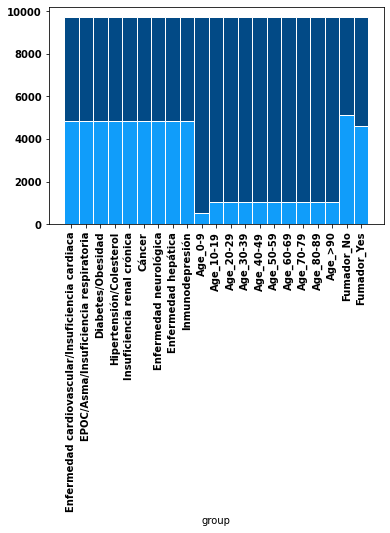

In [0]:
 
# y-axis in bold
rc('font', weight='bold')
 
# The position of the bars on the x-axis
r=[0]*col_number
for i in range(col_number):
  r[i] = i
 
# Names of group and bar width
names = col_names
barWidth = 1
 
# Create brown bars
plt.bar(r, afirmativo, color='#109DFA', edgecolor='white', width=barWidth)
# Create green bars (middle), on top of the firs ones
plt.bar(r, n_users, bottom=afirmativo, color='#024A86', edgecolor='white', width=barWidth)

# Custom X axis
plt.xticks(r, names, fontweight='bold')
plt.xlabel("group")
plt.xticks(rotation=90)
# Show graphic
plt.show()

Correlation matrix

Here we have the correlation between the variables of the dataset

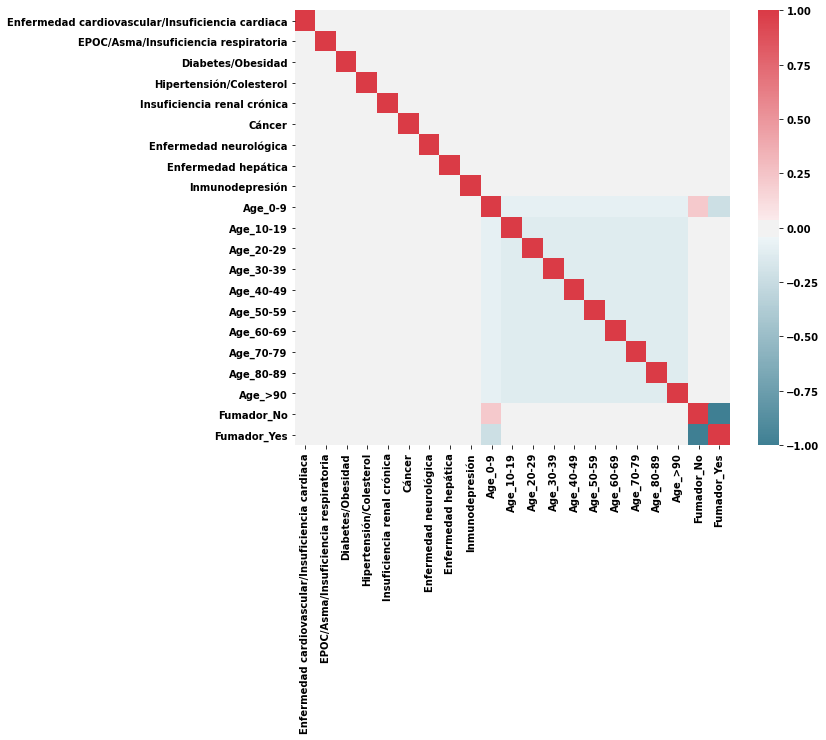

In [0]:
import seaborn as sns

f, ax = plt.subplots(figsize=(10, 8))
corr = final_data.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

## PROBABILITY FUNTION

Now let's give each of those variables a weight to compute the Lethality.

Definition of variables:


*   a to i: disease  
https://www.mscbs.gob.es/profesionales/saludPublica/ccayes/alertasActual/nCov-China/documentos/20200417_ITCoronavirus.pdf   Page 22
*   j to s: age
https://www.mscbs.gob.es/profesionales/saludPublica/ccayes/alertasActual/nCov-China/documentos/Actualizacion_94_COVID-19.pdf  
*   t: smoker
http://www.tobaccoinduceddiseases.org/COVID-19-and-smoking-A-systematic-review-of-the-evidence,119324,0,2.html

x1= total wight depending on disease variable.
x2= total weight depending on age variable.
x3= total weight depending on smoking variable.

The weights of each variable in the total model was checked by a healthy professional.

In [0]:
def Lethality(a,b,c,d,e,f,g,h,i,j,k,l,m,n,o,p,q,r,s,t): 

  #DISEASE = EACH DISEASE n * WEIGHT n
    each_disease=[a,b,c,d,e,f,g,h,i]
    weight_by_disease=(100,36.07,57.38,36.07,6.67,6.75,6.61,1.39,0.36)
    total_weight_disease= list(map(operator.mul, each_disease, weight_by_disease))
    disease=sum(total_weight_disease)

  #AGE= EACH AGE n * WEIGTH n
    each_age= [j,k,l,m,n,o,p,q,r,s]
    weight_by_age=(1.37,1.83,0.91,1.37,2.74,6.85,21.92,63.47,95.43,100)
    total_weight_age= list(map(operator.mul, each_age, weight_by_age))
    age=sum(total_weight_age)

  #SMOKER
    smoker= (100*t)

    if(disease >= 100):
      disease=100

    if (q==1 or r==1 or s ==1):     # People over 70 years old.
      disease=disease*0.5
      age=age*0.45
      smoker=smoker*0.05
    else:                           # People under 70 years old.
      disease=disease*0.6
      age=age*0.3
      smoker=smoker*0.1
         
    return (disease+age+smoker)

def Prob_lethality(): 
      
    final_data['Prob_lethality'] = final_data.apply(lambda row : Lethality(row['Enfermedad cardiovascular/Insuficiencia cardiaca'],row['EPOC/Asma/Insuficiencia respiratoria'],row['Diabetes/Obesidad'],
                                                                           row['Hipertensión/Colesterol'],row['Insuficiencia renal crónica'],row['Cáncer'],
                                                                           row['Enfermedad neurológica'],row['Enfermedad hepática'],row['Inmunodepresión'],
                                                                           row['Age_0-9'],row['Age_10-19'],row['Age_20-29'],
                                                                           row['Age_30-39'],row['Age_40-49'],row['Age_50-59'],
                                                                           row['Age_60-69'],row['Age_70-79'],row['Age_80-89'],
                                                                           row['Age_>90'],row['Fumador_Yes']), axis = 1) 
   
    return final_data

FINAL_DATA is created as the sum of the total weights.

In [0]:
FINAL_DATA=Prob_lethality()
FINAL_DATA

,Enfermedad cardiovascular/Insuficiencia cardiaca,EPOC/Asma/Insuficiencia respiratoria,Diabetes/Obesidad,Hipertensión/Colesterol,Insuficiencia renal crónica,Cáncer,Enfermedad neurológica,Enfermedad hepática,Inmunodepresión,Age_0-9,Age_10-19,Age_20-29,Age_30-39,Age_40-49,Age_50-59,Age_60-69,Age_70-79,Age_80-89,Age_>90,Fumador_No,Fumador_Yes,Prob_lethality
512,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0.411
513,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,60.411
514,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,22.053
515,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,60.411
516,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,34.839
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10235,1,1,0,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,1,1,0,95.000
10236,0,0,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,1,1,0,95.000
10237,1,0,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,1,1,0,95.000
10238,0,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,1,1,0,95.000


In [0]:
FINAL_DATA.loc[FINAL_DATA['Prob_lethality'] <= 25, 'State'] = 'Leve' 
FINAL_DATA.loc[(FINAL_DATA['Prob_lethality'] >25) & (FINAL_DATA['Prob_lethality'] <50), 'State'] = 'Grave'
FINAL_DATA.loc[FINAL_DATA['Prob_lethality'] >=50, 'State'] = 'Muy grave'  

In [0]:
FINAL_DATA

,Enfermedad cardiovascular/Insuficiencia cardiaca,EPOC/Asma/Insuficiencia respiratoria,Diabetes/Obesidad,Hipertensión/Colesterol,Insuficiencia renal crónica,Cáncer,Enfermedad neurológica,Enfermedad hepática,Inmunodepresión,Age_0-9,Age_10-19,Age_20-29,Age_30-39,Age_40-49,Age_50-59,Age_60-69,Age_70-79,Age_80-89,Age_>90,Fumador_No,Fumador_Yes,Prob_lethality,State
512,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0.411,Leve
513,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,60.411,Muy grave
514,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,22.053,Leve
515,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,60.411,Muy grave
516,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,34.839,Grave
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10235,1,1,0,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,1,1,0,95.000,Muy grave
10236,0,0,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,1,1,0,95.000,Muy grave
10237,1,0,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,1,1,0,95.000,Muy grave
10238,0,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,1,1,0,95.000,Muy grave


In [0]:
FINAL_DATA.groupby('State').count()

,Enfermedad cardiovascular/Insuficiencia cardiaca,EPOC/Asma/Insuficiencia respiratoria,Diabetes/Obesidad,Hipertensión/Colesterol,Insuficiencia renal crónica,Cáncer,Enfermedad neurológica,Enfermedad hepática,Inmunodepresión,Age_0-9,Age_10-19,Age_20-29,Age_30-39,Age_40-49,Age_50-59,Age_60-69,Age_70-79,Age_80-89,Age_>90,Fumador_No,Fumador_Yes,Prob_lethality
State,,,,,,,,,,,,,,,,,,,,,,
Grave,1275,1275,1275,1275,1275,1275,1275,1275,1275,1275,1275,1275,1275,1275,1275,1275,1275,1275,1275,1275,1275,1275
Leve,453,453,453,453,453,453,453,453,453,453,453,453,453,453,453,453,453,453,453,453,453,453
Muy grave,8000,8000,8000,8000,8000,8000,8000,8000,8000,8000,8000,8000,8000,8000,8000,8000,8000,8000,8000,8000,8000,8000


Barplot


In this plot it is shown the severity for each variable. It is ordered descending so on the left we have the variable which is the most affected and on the right the least one.

In [0]:
col_names = FINAL_DATA.columns.tolist()
col_number= len(col_names)

probabilidad = [0]*col_number
a=0

for i in col_names:
  mini=FINAL_DATA.loc[FINAL_DATA.loc[:, i] == 1]
  probabilidad[a]=mini['Prob_lethality'].mean()
  a=a+1

probabilidad= pd.DataFrame(probabilidad)
col_names =pd.DataFrame(col_names)
probabilidad = pd.concat([col_names,probabilidad], axis=1)
probabilidad.columns = ["Variables", "Probabilidad"]
probabilidad= probabilidad.dropna()

probabilidad = probabilidad.sort_values('Probabilidad', ascending = False)
probabilidad

,Variables,Probabilidad
18,Age_>90,89.834102
17,Age_80-89,87.777602
0,Enfermedad cardiovascular/Insuficiencia cardiaca,74.199632
16,Age_70-79,73.395602
2,Diabetes/Obesidad,71.844326
20,Fumador_Yes,70.444315
1,EPOC/Asma/Insuficiencia respiratoria,69.174834
3,Hipertensión/Colesterol,69.174834
5,Cáncer,66.134625
4,Insuficiencia renal crónica,66.127520


We show the probability per variable in a graph.

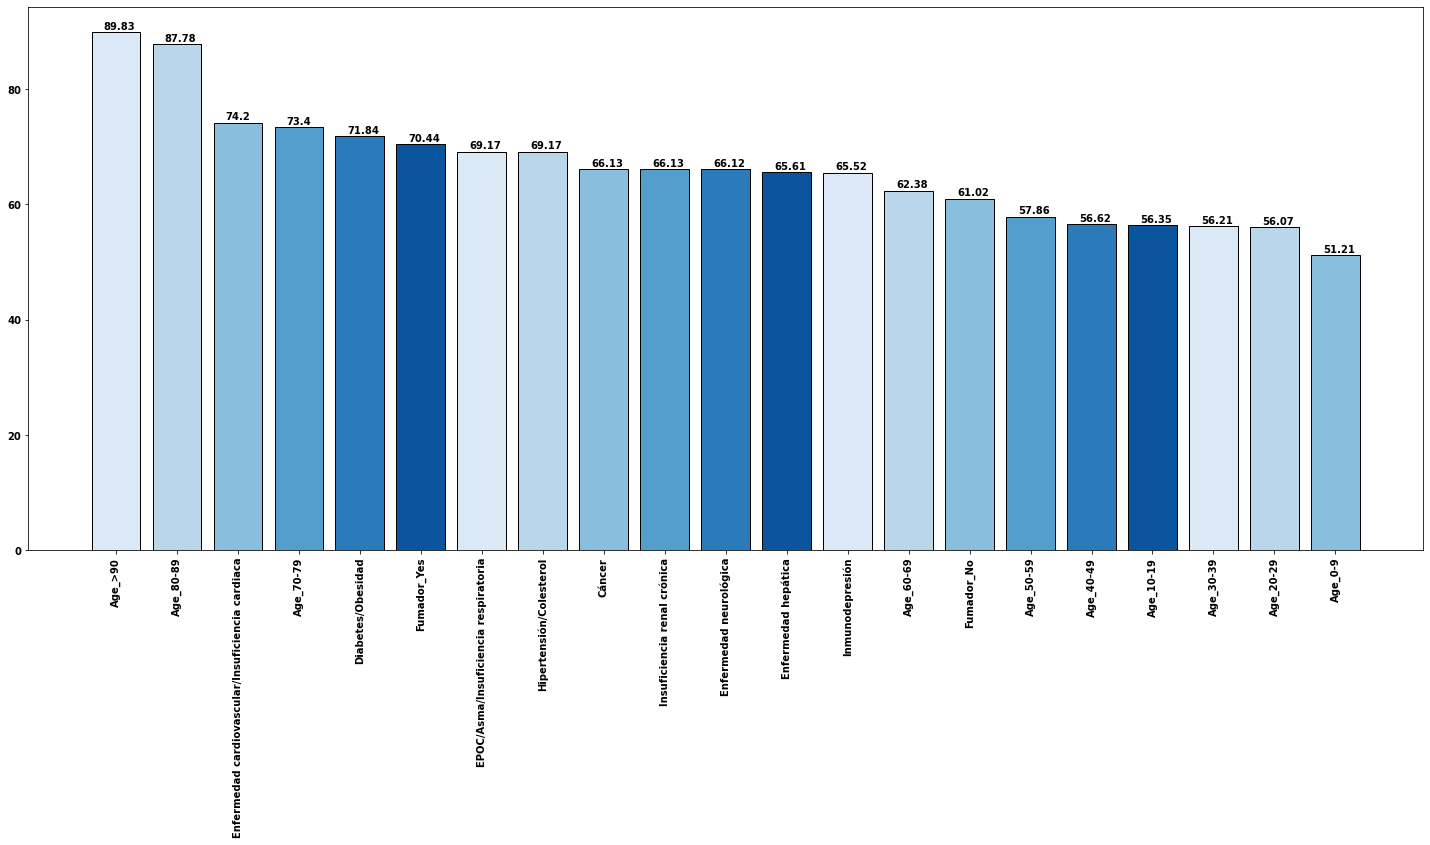

In [0]:
r4=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
probabilidad = probabilidad.sort_values('Probabilidad', ascending = False)
probabilidad=probabilidad.set_index(pd.Index(r4))
probabilidad = round(probabilidad,2)

plt.figure(figsize=(25,10))

#Plot the data:
my_colors = sns.color_palette("Blues")

plt.bar(r4, probabilidad['Probabilidad'], width = 0.8, edgecolor='black',color = my_colors)

plt.xticks([r for r in range(len(r4))],probabilidad['Variables'], rotation=90)
probabilidad
label = probabilidad['Probabilidad']

for i in range(len(r4)):
  plt.text(x = r4[i]-0.2 , y = round(probabilidad['Probabilidad'][i]+0.5,2), s = label[i], size = 10)
  

Heatmap

Here we have a heatmap where we can see the severity for each user age in case of having one of the diseases or if he smokes or not.

In [0]:
col_names = FINAL_DATA.columns.tolist()
col_number= len(col_names)
enfermedades = col_names[0:9]
edad=col_names[9:19]
fumador=col_names[19:21]

variables= ['Edad']+enfermedades+fumador

data = pd.DataFrame(columns=variables)
data['Edad']= edad
data


prob = [0]* len(edad)
a=0

for i in (enfermedades+fumador):
  for x in edad:
    mini=FINAL_DATA.loc[(FINAL_DATA.loc[:,i] == 1) & (FINAL_DATA.loc[:,x] == 1)]
    prob[a]=mini['Prob_lethality'].mean()
    a=a+1
  a=0
  data[i]= prob


data=data.set_index('Edad')
data = round(data,1)
data

,Enfermedad cardiovascular/Insuficiencia cardiaca,EPOC/Asma/Insuficiencia respiratoria,Diabetes/Obesidad,Hipertensión/Colesterol,Insuficiencia renal crónica,Cáncer,Enfermedad neurológica,Enfermedad hepática,Inmunodepresión,Fumador_No,Fumador_Yes
Edad,,,,,,,,,,,
Age_0-9,60.4,55.1,57.9,55.1,51.9,51.9,51.9,51.3,51.2,51.2,NaN
Age_10-19,65.5,60.2,63.1,60.2,57.0,57.0,57.0,56.5,56.4,51.3,61.3
Age_20-29,65.3,60.0,62.8,60.0,56.8,56.8,56.7,56.2,56.1,51.1,61.1
Age_30-39,65.4,60.1,62.9,60.1,56.9,56.9,56.9,56.3,56.2,51.2,61.2
Age_40-49,65.8,60.5,63.3,60.5,57.3,57.3,57.3,56.8,56.7,51.6,61.6
Age_50-59,67.1,61.8,64.6,61.8,58.5,58.5,58.5,58.0,57.9,52.9,62.9
Age_60-69,71.6,66.3,69.1,66.3,63.1,63.1,63.0,62.5,62.4,57.4,67.4
Age_70-79,81.1,76.6,79.0,76.6,74.0,74.0,74.0,73.5,73.4,70.9,75.9
Age_80-89,95.4,91.0,93.4,91.0,88.3,88.3,88.3,87.9,87.8,85.3,90.3


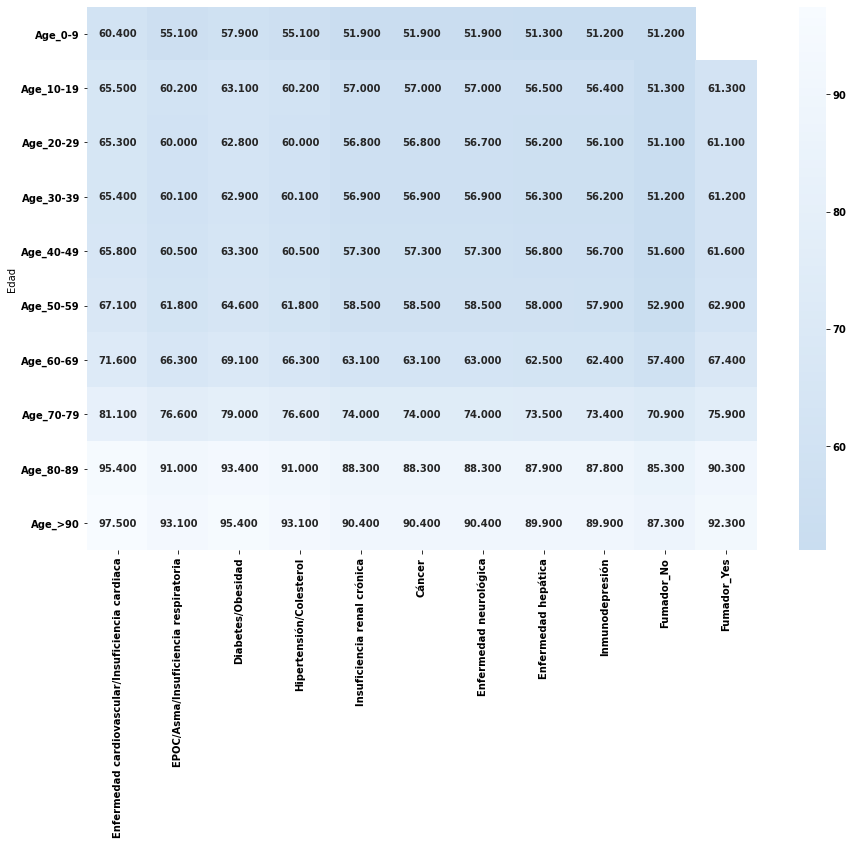

In [0]:
fig, ax = plt.subplots(figsize=(15,10))      

sns.heatmap(data, center=0, cmap='Blues_r', annot=True, fmt='.3f',ax=ax)

Here we have a correlation matrix of the variable

In [0]:
data_age_0_9= FINAL_DATA[FINAL_DATA['Age_0-9'] == 1]
res1=data_age_0_9['Prob_lethality'].describe()
min1=res1[3]

In [0]:
data_age_0_9['Prob_lethality'].describe()

count    512.000000
mean      51.211922
std       15.945807
min        0.411000
25%       46.329000
50%       60.411000
75%       60.411000
max       60.411000
Name: Prob_lethality, dtype: float64

In [0]:
data_age_0_9

,Enfermedad cardiovascular/Insuficiencia cardiaca,EPOC/Asma/Insuficiencia respiratoria,Diabetes/Obesidad,Hipertensión/Colesterol,Insuficiencia renal crónica,Cáncer,Enfermedad neurológica,Enfermedad hepática,Inmunodepresión,Age_0-9,Age_10-19,Age_20-29,Age_30-39,Age_40-49,Age_50-59,Age_60-69,Age_70-79,Age_80-89,Age_>90,Fumador_No,Fumador_Yes,Prob_lethality
512,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0.411
513,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,60.411
514,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,22.053
515,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,60.411
516,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,34.839
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1019,1,1,0,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,1,0,60.411
1020,0,0,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,1,0,60.411
1021,1,0,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,1,0,60.411
1022,0,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,1,0,60.411


In [0]:
data_age_10_19= FINAL_DATA[FINAL_DATA['Age_10-19'] == 1]
res2=data_age_10_19['Prob_lethality'].describe()
min2=res2[3]
mean2=res2[5]

In [0]:
data_age_10_19['Prob_lethality'].describe()

count    1024.000000
mean       56.349922
std        16.704630
min         0.549000
25%        51.370000
50%        60.549000
75%        70.549000
max        70.549000
Name: Prob_lethality, dtype: float64

In [0]:
data_age_20_29= FINAL_DATA[FINAL_DATA['Age_20-29'] == 1]
res3=data_age_20_29['Prob_lethality'].describe()
min3=res3[3]

In [0]:
data_age_30_39= FINAL_DATA[FINAL_DATA['Age_30-39'] == 1]
res4=data_age_30_39['Prob_lethality'].describe()
min4=res4[3]

In [0]:
data_age_40_49= FINAL_DATA[FINAL_DATA['Age_40-49'] == 1]
res5=data_age_40_49['Prob_lethality'].describe()
min5=res5[3]

In [0]:
data_age_50_59= FINAL_DATA[FINAL_DATA['Age_50-59'] == 1]
res6=data_age_50_59['Prob_lethality'].describe()
min6=res6[3]

In [0]:
data_age_60_69= FINAL_DATA[FINAL_DATA['Age_60-69'] == 1]
res7=data_age_60_69['Prob_lethality'].describe()
min7=res7[3]

In [0]:
data_age_70_79= FINAL_DATA[FINAL_DATA['Age_70-79'] == 1]
res8=data_age_70_79['Prob_lethality'].describe()
min8=res8[3]

In [0]:
data_age_80_89= FINAL_DATA[FINAL_DATA['Age_80-89'] == 1]
res9=data_age_80_89['Prob_lethality'].describe()
min9=res9[3]

In [0]:
data_age_90= FINAL_DATA[FINAL_DATA['Age_>90'] == 1]
res10=data_age_90['Prob_lethality'].describe()
min10=res10[3]

Text(0.5, 0, '$\\it{Source}$: Own elaboration')

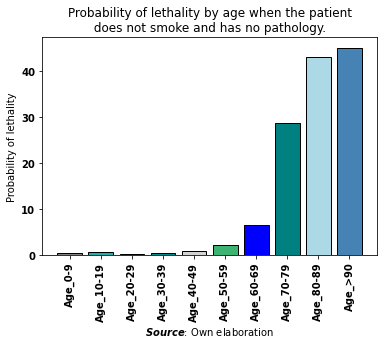

In [0]:
edad=['Age_0-9', 'Age_10-19', 'Age_20-29', 'Age_30-39', 'Age_40-49', 'Age_50-59', 'Age_60-69', 'Age_70-79', 'Age_80-89', 'Age_>90']
min_edad= [min1, min2, min3, min4, min5, min6, min7, min8, min9, min10]


plt.bar(edad,min_edad ,edgecolor = 'black', color=['gray', 'lightseagreen', 'paleturquoise', 'darkcyan', 'lightgray','mediumseagreen', 'blue','teal','lightblue', 'steelblue'])
plt.xticks(rotation='vertical')
plt.title('Probability of lethality by age when the patient''\n'' does not smoke and has no pathology. ')
plt.ylabel('Probability of lethality')
plt.xlabel(r"$\it{"+'Source'+ "}$"+': Own elaboration')

In [0]:
dis_cardio = FINAL_DATA.columns[0]
dis_no_cardio= FINAL_DATA.columns[1:8]
no_fum= FINAL_DATA.columns[19]
age= FINAL_DATA.columns[9:19]

In [0]:
data_cardio=pd.DataFrame()
data_cardio= FINAL_DATA[FINAL_DATA['Enfermedad cardiovascular/Insuficiencia cardiaca'] == 1]
data_cardio

,Enfermedad cardiovascular/Insuficiencia cardiaca,EPOC/Asma/Insuficiencia respiratoria,Diabetes/Obesidad,Hipertensión/Colesterol,Insuficiencia renal crónica,Cáncer,Enfermedad neurológica,Enfermedad hepática,Inmunodepresión,Age_0-9,Age_10-19,Age_20-29,Age_30-39,Age_40-49,Age_50-59,Age_60-69,Age_70-79,Age_80-89,Age_>90,Fumador_No,Fumador_Yes,Prob_lethality
513,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,60.411
515,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,60.411
517,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,60.411
519,1,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,60.411
521,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,60.411
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10231,1,1,1,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,1,1,0,95.000
10233,1,0,0,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,1,1,0,95.000
10235,1,1,0,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,1,1,0,95.000
10237,1,0,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,1,1,0,95.000


In [0]:
df=pd.DataFrame(FINAL_DATA)
df

,Enfermedad cardiovascular/Insuficiencia cardiaca,EPOC/Asma/Insuficiencia respiratoria,Diabetes/Obesidad,Hipertensión/Colesterol,Insuficiencia renal crónica,Cáncer,Enfermedad neurológica,Enfermedad hepática,Inmunodepresión,Age_0-9,Age_10-19,Age_20-29,Age_30-39,Age_40-49,Age_50-59,Age_60-69,Age_70-79,Age_80-89,Age_>90,Fumador_No,Fumador_Yes,Prob_lethality
512,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0.411
513,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,60.411
514,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,22.053
515,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,60.411
516,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,34.839
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10235,1,1,0,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,1,1,0,95.000
10236,0,0,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,1,1,0,95.000
10237,1,0,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,1,1,0,95.000
10238,0,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,1,1,0,95.000


In [0]:
df.columns

Index(['Enfermedad cardiovascular/Insuficiencia cardiaca',
       'EPOC/Asma/Insuficiencia respiratoria', 'Diabetes/Obesidad',
       'Hipertensión/Colesterol', 'Insuficiencia renal crónica', 'Cáncer',
       'Enfermedad neurológica', 'Enfermedad hepática', 'Inmunodepresión',
       'Age_0-9', 'Age_10-19', 'Age_20-29', 'Age_30-39', 'Age_40-49',
       'Age_50-59', 'Age_60-69', 'Age_70-79', 'Age_80-89', 'Age_>90',
       'Fumador_No', 'Fumador_Yes', 'Prob_lethality'],
      dtype='object')

In [0]:
df['count_diseases'] =  df[['Enfermedad cardiovascular/Insuficiencia cardiaca',
       'EPOC/Asma/Insuficiencia respiratoria', 'Diabetes/Obesidad',
       'Hipertensión/Colesterol', 'Insuficiencia renal crónica', 'Cáncer',
       'Enfermedad neurológica', 'Enfermedad hepática', 'Inmunodepresión']].sum(axis=1)

df

,Enfermedad cardiovascular/Insuficiencia cardiaca,EPOC/Asma/Insuficiencia respiratoria,Diabetes/Obesidad,Hipertensión/Colesterol,Insuficiencia renal crónica,Cáncer,Enfermedad neurológica,Enfermedad hepática,Inmunodepresión,Age_0-9,Age_10-19,Age_20-29,Age_30-39,Age_40-49,Age_50-59,Age_60-69,Age_70-79,Age_80-89,Age_>90,Fumador_No,Fumador_Yes,Prob_lethality,count_diseases
512,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0.411,0
513,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,60.411,1
514,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,22.053,1
515,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,60.411,2
516,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,34.839,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10235,1,1,0,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,1,1,0,95.000,8
10236,0,0,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,1,1,0,95.000,7
10237,1,0,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,1,1,0,95.000,8
10238,0,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,1,1,0,95.000,8


In [0]:
df = df[df.count_diseases == 1]
df

,Enfermedad cardiovascular/Insuficiencia cardiaca,EPOC/Asma/Insuficiencia respiratoria,Diabetes/Obesidad,Hipertensión/Colesterol,Insuficiencia renal crónica,Cáncer,Enfermedad neurológica,Enfermedad hepática,Inmunodepresión,Age_0-9,Age_10-19,Age_20-29,Age_30-39,Age_40-49,Age_50-59,Age_60-69,Age_70-79,Age_80-89,Age_>90,Fumador_No,Fumador_Yes,Prob_lethality,count_diseases
513,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,60.411,1
514,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,22.053,1
516,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,34.839,1
520,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,22.053,1
528,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,4.413,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9744,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,48.335,1
9760,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,48.375,1
9792,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,48.305,1
9856,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,45.695,1


In [0]:
df_no_fumador = df[df.Fumador_No == 1]
df_no_fumador

,Enfermedad cardiovascular/Insuficiencia cardiaca,EPOC/Asma/Insuficiencia respiratoria,Diabetes/Obesidad,Hipertensión/Colesterol,Insuficiencia renal crónica,Cáncer,Enfermedad neurológica,Enfermedad hepática,Inmunodepresión,Age_0-9,Age_10-19,Age_20-29,Age_30-39,Age_40-49,Age_50-59,Age_60-69,Age_70-79,Age_80-89,Age_>90,Fumador_No,Fumador_Yes,Prob_lethality,count_diseases
513,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,60.411,1
514,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,22.053,1
516,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,34.839,1
520,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,22.053,1
528,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,4.413,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9744,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,48.335,1
9760,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,48.375,1
9792,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,48.305,1
9856,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,45.695,1


In [0]:
df_fumador = df[df.Fumador_Yes == 1]
df_fumador

,Enfermedad cardiovascular/Insuficiencia cardiaca,EPOC/Asma/Insuficiencia respiratoria,Diabetes/Obesidad,Hipertensión/Colesterol,Insuficiencia renal crónica,Cáncer,Enfermedad neurológica,Enfermedad hepática,Inmunodepresión,Age_0-9,Age_10-19,Age_20-29,Age_30-39,Age_40-49,Age_50-59,Age_60-69,Age_70-79,Age_80-89,Age_>90,Fumador_No,Fumador_Yes,Prob_lethality,count_diseases
1025,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,70.549,1
1026,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,32.191,1
1028,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,44.977,1
1032,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,32.191,1
1040,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,14.551,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9232,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,53.335,1
9248,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,53.375,1
9280,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,53.305,1
9344,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,50.695,1


In [0]:
col_names = df_no_fumador.columns.tolist()
col_number= len(col_names)
enfermedades = col_names[0:9]
edad=col_names[9:19]


variables= ['Edad']+enfermedades

data1 = pd.DataFrame(columns=variables)
data1['Edad']= edad
data1


prob = [0]* len(edad)
a=0

for i in (enfermedades):
  for x in edad:
    mini=df_no_fumador.loc[(df_no_fumador.loc[:,i] == 1) & (df_no_fumador.loc[:,x] == 1)]
    prob[a]=mini['Prob_lethality'].mean()
    a=a+1
  a=0
  data1[i]= prob


data1=data1.set_index('Edad')
data1 = round(data1,1)
data1

,Enfermedad cardiovascular/Insuficiencia cardiaca,EPOC/Asma/Insuficiencia respiratoria,Diabetes/Obesidad,Hipertensión/Colesterol,Insuficiencia renal crónica,Cáncer,Enfermedad neurológica,Enfermedad hepática,Inmunodepresión
Edad,,,,,,,,,
Age_0-9,60.4,22.1,34.8,22.1,4.4,4.5,4.4,1.2,0.6
Age_10-19,60.5,22.2,35.0,22.2,4.6,4.6,4.5,1.4,0.8
Age_20-29,60.3,21.9,34.7,21.9,4.3,4.3,4.2,1.1,0.5
Age_30-39,60.4,22.1,34.8,22.1,4.4,4.5,4.4,1.2,0.6
Age_40-49,60.8,22.5,35.2,22.5,4.8,4.9,4.8,1.7,1.0
Age_50-59,62.1,23.7,36.5,23.7,6.1,6.1,6.0,2.9,2.3
Age_60-69,66.6,28.2,41.0,28.2,10.6,10.6,10.5,7.4,6.8
Age_70-79,78.6,46.6,57.3,46.6,31.9,31.9,31.9,29.3,28.7
Age_80-89,92.9,61.0,71.6,61.0,46.3,46.3,46.2,43.6,43.1


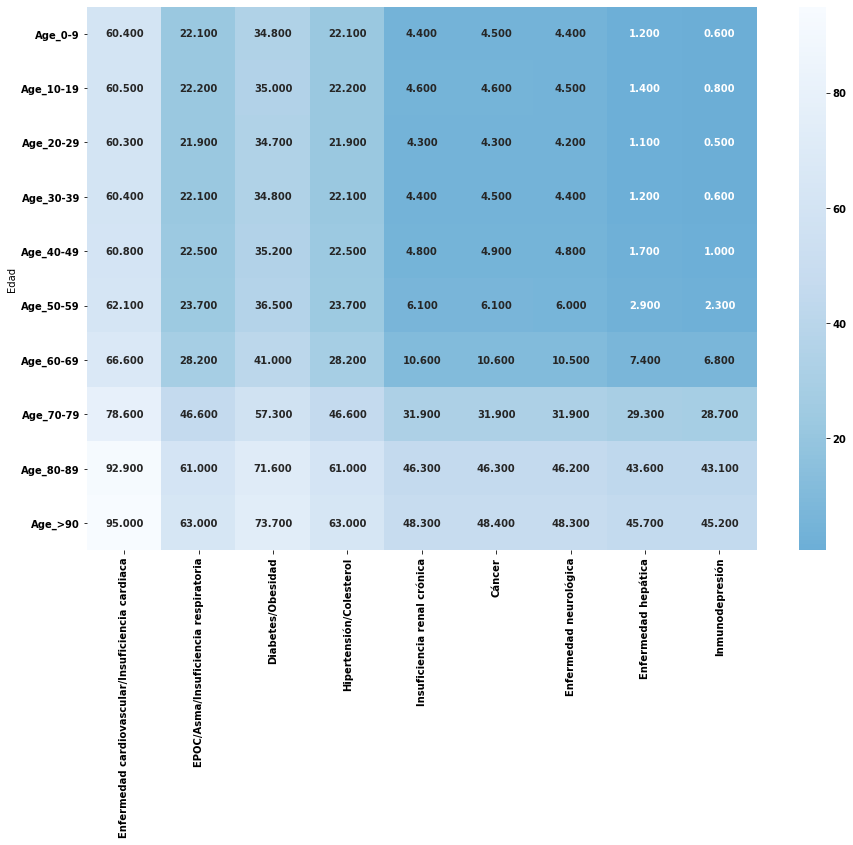

In [0]:
fig, ax = plt.subplots(figsize=(15,10))      

sns.heatmap(data1, center=0, cmap='Blues_r', annot=True, fmt='.3f',ax=ax)

In [0]:
col_names = df_fumador.columns.tolist()
col_number= len(col_names)
enfermedades = col_names[0:9]
edad=col_names[9:19]


variables= ['Edad']+enfermedades

data2 = pd.DataFrame(columns=variables)
data2['Edad']= edad
data2


prob = [0]* len(edad)
a=0

for i in (enfermedades):
  for x in edad:
    mini=df_fumador.loc[(df_fumador.loc[:,i] == 1) & (df_fumador.loc[:,x] == 1)]
    prob[a]=mini['Prob_lethality'].mean()
    a=a+1
  a=0
  data2[i]= prob


data2=data2.set_index('Edad')
data2 = round(data2,1)
data2

,Enfermedad cardiovascular/Insuficiencia cardiaca,EPOC/Asma/Insuficiencia respiratoria,Diabetes/Obesidad,Hipertensión/Colesterol,Insuficiencia renal crónica,Cáncer,Enfermedad neurológica,Enfermedad hepática,Inmunodepresión
Edad,,,,,,,,,
Age_0-9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age_10-19,70.5,32.2,45.0,32.2,14.6,14.6,14.5,11.4,10.8
Age_20-29,70.3,31.9,44.7,31.9,14.3,14.3,14.2,11.1,10.5
Age_30-39,70.4,32.1,44.8,32.1,14.4,14.5,14.4,11.2,10.6
Age_40-49,70.8,32.5,45.2,32.5,14.8,14.9,14.8,11.7,11.0
Age_50-59,72.1,33.7,46.5,33.7,16.1,16.1,16.0,12.9,12.3
Age_60-69,76.6,38.2,51.0,38.2,20.6,20.6,20.5,17.4,16.8
Age_70-79,83.6,51.6,62.3,51.6,36.9,36.9,36.9,34.3,33.7
Age_80-89,97.9,66.0,76.6,66.0,51.3,51.3,51.2,48.6,48.1


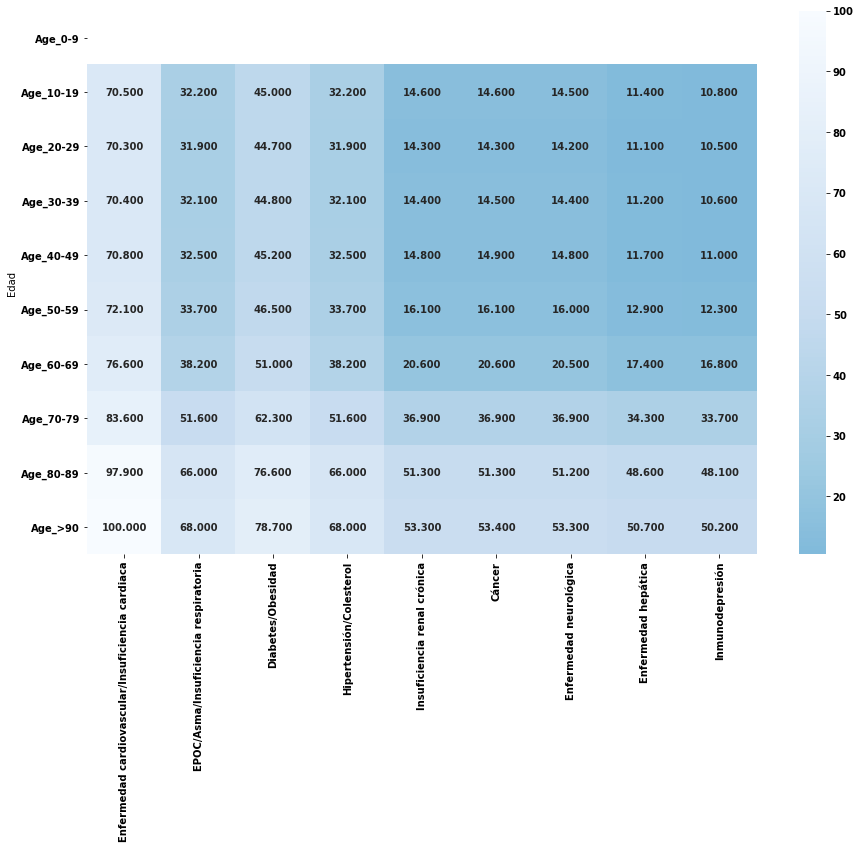

In [0]:
fig, ax = plt.subplots(figsize=(15,10))      

sns.heatmap(data2, center=0, cmap='Blues_r', annot=True, fmt='.3f',ax=ax)

HOPE YOU ENJOYED :)

# EXPORT DATASET

In [0]:
from google.colab import drive
drive.mount('drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at drive


In [0]:
FINAL_DATA.to_csv('final_severity_dataset.csv', index=False)
!cp final_severity_dataset.csv "/content/drive/My Drive"